In [2]:



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd


df = pd.read_csv('train_u6lujuX_CVtuZ9i (1).csv')

# Quick check
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [ ]:
# ## 2.1 Quick data sanity check
# Show basic info, sample rows and types so we know what we have.
# Cell: basic inspection
import pandas as pd
pd.set_option("display.max_columns", 200)



print("Shape:", df.shape)
print("\nColumn dtypes:")
print(df.dtypes)
print("\nFirst 5 rows:")
display(df.head())

# show a random sample too
print("\nRandom sample:")
display(df.sample(5, random_state=42))


Shape: (614, 13)

Column dtypes:
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

First 5 rows:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y



Random sample:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
350,LP002139,Male,Yes,0,Graduate,No,9083,0.0,228.0,360.0,1.0,Semiurban,Y
377,LP002223,Male,Yes,0,Graduate,No,4310,0.0,130.0,360.0,NaN,Semiurban,Y
163,LP001570,Male,Yes,2,Graduate,No,4167,1447.0,158.0,360.0,1.0,Rural,Y
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
132,LP001478,Male,No,0,Graduate,No,2718,0.0,70.0,360.0,1.0,Semiurban,Y


In [ ]:
#checking missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
#pct stands for percentage
missing_df = pd.concat([missing, missing_pct], axis=1)
missing_df.columns = ["missing_count", "missing_pct"]
missing_df[missing_df.missing_count > 0]

,missing_count,missing_pct
Credit_History,50,8.14
Self_Employed,32,5.21
LoanAmount,22,3.58
Dependents,15,2.44
Loan_Amount_Term,14,2.28
Gender,13,2.12
Married,3,0.49


In [ ]:
# Step 3 — Handle missing values

# Categorical features — substitute missing variables with mode (most frequent)
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Numeric features — fill with median or mode as appropriate
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Check again if the data still has any missing value
df.isnull().sum()


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [ ]:
# Step 4 — Target balance check, to check the number of loans approved vs not approved
print("Loan_Status value counts:")
print(df["Loan_Status"].value_counts())

print("\nPercentage distribution:")
print((df["Loan_Status"].value_counts(normalize=True) * 100).round(2))


Loan_Status value counts:
Loan_Status
Y    422
N    192
Name: count, dtype: int64

Percentage distribution:
Loan_Status
Y    68.73
N    31.27
Name: proportion, dtype: float64


In [8]:
# Step 5.1 — Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", cat_cols)


Categorical columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


In [9]:
#Encode categorical variables

# Drop ID column
df.drop('Loan_ID', axis=1, inplace=True)

# Binary categorical mappings
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Education'] = df['Education'].map({'Graduate': 1, 'Not Graduate': 0})
df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})  # Target variable

# Clean 'Dependents'
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)

# One-hot encode Property_Area (drop_first=True avoids dummy trap)
df = pd.get_dummies(df, columns=['Property_Area'], drop_first=True)

# Check result
df.head()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Semiurban,Property_Area_Urban
0,1,0,0,1,0,5849,0.0,128.0,360.0,1.0,1,False,True
1,1,1,1,1,0,4583,1508.0,128.0,360.0,1.0,0,False,False
2,1,1,0,1,1,3000,0.0,66.0,360.0,1.0,1,False,True
3,1,1,0,0,0,2583,2358.0,120.0,360.0,1.0,1,False,True
4,1,0,0,1,0,6000,0.0,141.0,360.0,1.0,1,False,True


In [10]:
# Train-Test Split + Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)


Training shape: (491, 12)
Test shape: (123, 12)


Accuracy: 0.8211

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70        38
           1       0.86      0.88      0.87        85

    accuracy                           0.82       123
   macro avg       0.79      0.78      0.79       123
weighted avg       0.82      0.82      0.82       123



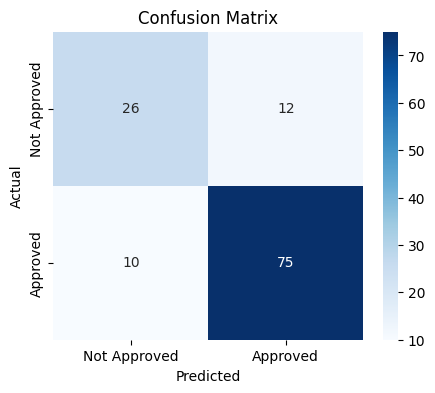

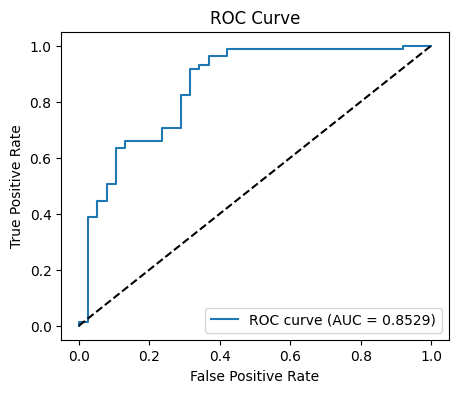

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Logistic Regression
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Fit on training data
model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Approved','Approved'], yticklabels=['Not Approved','Approved'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
